SystemExit: 0

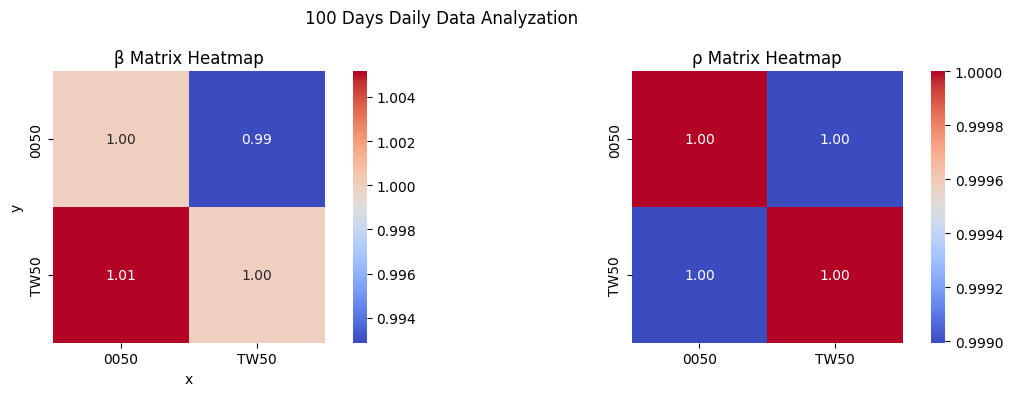

In [31]:
import numpy as np
import pandas as pd
import pyodbc
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
# import matplotlib.figure as figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from tkinter import messagebox
from pandas.tseries.offsets import BDay
import json
import os
import warnings
import sys
warnings.filterwarnings("ignore")

indices = ['TWA02', 'TWA23', 'TWA60', 'TWA28', 'TWC02', 'TWC66']

# Step 1: Get all ETFs we have. 
def fetching_ids():
    conn_str = (
        r'DRIVER={SQL Server};'
        r'SERVER=172.19.139.103;'
        r'DATABASE=DataPool;'
        r'UID=datareader;'
        r'PWD=datareader;'
    )
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM [DataPool].[dbo].[ETFSetting] where APP =  \'PhysicalEtfSender\' OR APP = \'DomeCash2EtfSender\'')
    rows = cursor.fetchall()
    totally = []
    for row in rows:
        totally.append(row[0][:-3])
    totally = sorted(list(set(totally)))
    conn.close()
    # totally.extend(indices)
    return totally 

# Step 2: Get the components of those ETFs along with their weights
def fetching_weights(all_ETFs):
    conn_str = (
        r'DRIVER={SQL Server};'
        r'SERVER=172.19.139.103;'
        r'DATABASE=DataPool;'
        r'UID=datareader;'
        r'PWD=datareader;'
    )
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    
    weights_df = {}
    drop_list = []
    
    for id in all_ETFs:

        cursor.execute('SELECT * FROM [DataPool].[dbo].[WebWeightShares] WHERE IndSymbol = \''+str(".")+ id+'\'')
        rows = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df = pd.DataFrame.from_records(rows, columns=columns, index = 'RecordDate')
        
        df = df.transpose()
        df.columns = df.loc["Symbol"]
        df.drop([weight for weight in df.index if weight not in ["Weight", "Product", "Symbol"]]
                    , inplace = True)
        df_transposed = df.T
        
        if (len(df_transposed) == 0): 
            drop_list.append(id)
            continue
        
        columns_to_rename_TXF = df_transposed[(df_transposed['Product'] == 'FUTURES') & 
                                            (df_transposed['Symbol'].str.startswith(('TXF', 'MXF')))].index
        columns_to_rename_EXF_ZXF = df_transposed[(df_transposed['Product'] == 'FUTURES') & 
                                                (df_transposed['Symbol'].str.startswith(('EXF', 'ZXF', 'ZEF')))].index
        columns_to_rename_NTF = df_transposed[(df_transposed['Product'] == 'FUTURES') & 
                                            (df_transposed['Symbol'].str.startswith('NYF'))].index
        columns_to_rename_FXF = df_transposed[(df_transposed['Product'] == 'FUTURES') & 
                                            (df_transposed['Symbol'].str.startswith('FXF'))].index
        columns_to_rename_TWC02= df_transposed[(df_transposed['Product'] == 'FUTURES') & 
                                            (df_transposed['Symbol'].str.startswith('GTF'))].index
        columns_to_rename_TWC66= df_transposed[(df_transposed['Product'] == 'FUTURES') & 
                                            (df_transposed['Symbol'].str.startswith('G2F'))].index
        df.rename(columns={col: 'TWA02' for col in columns_to_rename_TXF}, inplace=True)
        df.rename(columns={col: 'TWA23' for col in columns_to_rename_EXF_ZXF}, inplace=True)
        df.rename(columns={col: 'TWA60' for col in columns_to_rename_NTF}, inplace=True)
        df.rename(columns={col: 'TWA28' for col in columns_to_rename_FXF}, inplace=True)
        df.rename(columns={col: 'TWC02' for col in columns_to_rename_TWC02}, inplace=True)
        df.rename(columns={col: 'TWC66' for col in columns_to_rename_TWC66}, inplace=True)
        
        weights_df[id] = df
        
    conn.close()
    print(drop_list)
    return weights_df, drop_list

# Step 3: Get the combination of the components of all ETFs
def fetching_combination_components(weights_of_all_ETFs):
    all_components = []
    for key in weights_of_all_ETFs.keys():
        all_components.extend(weights_of_all_ETFs[key].columns)
    all_components = sorted(list(set(all_components)))
    
    return all_components

# Step 4: Get all closing price we might need
def fetching_closing(components_ids):
    df = pd.DataFrame()
    conn_str = (
        r'DRIVER={SQL Server};'
        r'SERVER=172.19.139.103;'
        r'DATABASE=DataPool;'
        r'UID=datareader;'
        r'PWD=datareader;'
    )
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    for id in components_ids: 
        sql_query = '''SELECT * FROM (
                        SELECT TOP ''' + str(800) + ''' [RecordDate], [Symbol], [YesterdayClose], 
                        ROW_NUMBER() OVER (ORDER BY [RecordDate] DESC) as rn 
                        FROM [DataPool].[dbo].[StocksReturnPrice] 
                        WHERE Symbol = \'''' + str(id) + '''\') tmp
                        WHERE rn <= ''' + str(800) + ''' ORDER BY [RecordDate] ASC'''
        cursor.execute(sql_query)
        rows = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df_closing = pd.DataFrame.from_records(rows, columns=columns)
        df_closing.set_index('RecordDate', inplace=True)
        df = pd.concat([df, df_closing["YesterdayClose"]], axis =1, join = "outer")
        
    df.columns = components_ids
    conn.close()
    
    return df

# Step 5: Analyze the data
def calculate_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(lambda x: np.log(x / x.shift(1)))

def analyzer(test_list, num_of_days):
    features = pd.DataFrame()
    needed_stocks = []
    needed_weights ={}
    
    # Check if the latest date in the data is the most recent weekday
    latest_date_in_df = pd.to_datetime(closing_price_all_components.index)[-1]
    most_recent_weekday = pd.Timestamp('today') - BDay(1)
    if latest_date_in_df.date() != most_recent_weekday.date():
        warning_message = f"The latest date in the data is {latest_date_in_df.strftime('%Y-%m-%d')}, which is not the most recent weekday ({most_recent_weekday.strftime('%Y-%m-%d')}). Please update the database."
        messagebox.showwarning("Warning", warning_message)

    try:
        # First check if it's a float (which also handles integers)
        num = float(num_of_days)
        if not num.is_integer() or num <= 0:
            raise ValueError
        # If the above check passed, we know it's a positive integer, but still a float, so let's convert to int
        num_of_days = int(num)
    except ValueError:
        error_message = "Invalid number of days. Please enter a positive integer."
        messagebox.showerror("Error", error_message)
        return
    
    # Check if at least one checkbox is checked
    if not test_list:
        error_message = "No ETFs selected. Please select at least one ETF."
        messagebox.showerror("Error", error_message)
        return
    
    
    for ETF_id in test_list:
        if ETF_id not in indices:
            needed_weights[ETF_id] = weights_of_all_ETFs[ETF_id]
            needed_stocks.extend(needed_weights[ETF_id].columns)
        else: 
            needed_stocks.extend(indices)

    needed_stocks = sorted(list(set(needed_stocks)))
    needed_closing_prices = closing_price_all_components[needed_stocks]

    if len(needed_closing_prices.dropna()) == 0:
        nan_cols = needed_closing_prices.columns[needed_closing_prices.isna().all()].tolist()
        error_message = (f"The closing price of {nan_cols} containing only NaN values. ")
        messagebox.showerror("Error", error_message)
        return
    elif len(needed_closing_prices.dropna()) < num_of_days: 
        error_message = (f"Not enough data for this combination. Only {len(needed_closing_prices.dropna())} days available.")
        messagebox.showerror("Error", error_message)
        return 
        
    elif len(needed_closing_prices.dropna()) == num_of_days: 
        error_message = (f"Not enough data for this combination. Only {len(needed_closing_prices.dropna())} days available. (Need extra 1 day for calculating the return)")
        messagebox.showerror("Error", error_message)
        return

    else: 
        needed_return = calculate_log_returns(needed_closing_prices.dropna()[-num_of_days-1:])[1:]
        
        for key in needed_weights.keys():
            ETF_return = needed_return[needed_weights[key].columns].mul(needed_weights[key].loc["Weight"]).sum(axis = 1)
            features = pd.concat([features, ETF_return], axis = 1, join = 'outer')
            
        for key in test_list:
            if key in indices:
                ETF_return = needed_return[key]
                features = pd.concat([features, ETF_return], axis = 1, join = 'outer')
            
    
        features.columns = test_list

        names = []
        for name in features.columns:
            if name in indices: 
                if name == 'TWA02':
                    names.append('TRX')
                elif name == 'TWA23':
                    names.append('Elec')
                elif name == 'TWA60':
                    names.append('TW50')
                elif name == 'TWA28':
                    names.append('BKI')
                elif name == 'TWC02':
                    names.append('OTC')
                elif name == 'TWC66':
                    names.append('TPEx200')
                    
            else:
                names.append(name)
        
        index = pd.MultiIndex.from_product([features.columns, features.columns], names=['y', 'x'])
        slope_series = pd.Series(index=index)

        slope_matrix = pd.DataFrame(index=features.columns, columns=features.columns)
        for i in features.columns:
            for j in features.columns:
                x = features[i].values
                y = features[j].values
                x = x.reshape(-1, 1)
                model = LinearRegression()
                model.fit(x, y)
                slope_series.loc[(i, j)] = round(model.coef_[0], 5)
                
        slope_matrix = slope_series.unstack(level=-1)
        correlation_matrix = features.corr()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        font_size = min(fig.get_size_inches()) * (2.5- 0.06*(len(features.columns) - 2))
        fig.suptitle(f"{num_of_days} Days Daily Data Analyzation")
        plt.rcParams.update({'font.size': font_size})
        sns.heatmap(slope_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
                    square=True, ax=ax1, xticklabels=names, yticklabels=names)
        ax1.set_title('β Matrix Heatmap')
        ax1.tick_params(axis='both', which='major', labelsize=font_size)
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
                    square=True, ax=ax2, xticklabels=names, yticklabels=names)
        ax2.set_title('ρ Matrix Heatmap')
        ax2.tick_params(axis='both', which='major', labelsize=font_size)
        fig.tight_layout()
    
        # Clear previous canvas
        for widget in plot_frame.winfo_children():
            widget.destroy()
        
        canvas = FigureCanvasTkAgg(fig, master=plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()
        canvas.get_tk_widget().config(width=1200, height=400)  # Set canvas size
        toolbar = NavigationToolbar2Tk(canvas, plot_frame)
        toolbar.update()
            
# Initialize the data
def initialize_data():
    global all_ETFs, weights_of_all_ETFs, combination_of_components_all_ETFs, closing_price_all_components
    all_ETFs = fetching_ids()
    weights_of_all_ETFs, drop_list = fetching_weights(all_ETFs)
    all_ETFs = [x for x in all_ETFs if x not in drop_list]
    combination_of_components_all_ETFs = fetching_combination_components(weights_of_all_ETFs)
    closing_price_all_components = fetching_closing(combination_of_components_all_ETFs)
    all_ETFs.extend(indices)
    
    


if "all_ETFs" not in globals():
    initialize_data()
    
def save_selections():
    selections = {
        'num_of_days': days_var.get(),
        'selected_etfs': [var.name for var in ETFs_vars if var.get()]
    }
    with open('selections.json', 'w') as file:
        json.dump(selections, file)

def load_selections():
    if os.path.exists('selections.json'):
        with open('selections.json', 'r') as file:
            selections = json.load(file)
        days_var.set(selections['num_of_days'])
        for etf in selections['selected_etfs']:
            for var in ETFs_vars:
                if var.name == etf:
                    var.set(etf)


def run_analyzer():
    num_days = days_var.get()
    try:
        num_days = int(num_days)
    except ValueError:
        messagebox.showerror("Error", "Invalid number of days. Please enter a positive integer.")
        return
    selected_ETFs = [var.get() for var in ETFs_vars if var.get()]
    try:
        analyzer(selected_ETFs, num_days)
        output_text.set("Successfully completed!")
    except Exception as e:
        output_text.set(f"An error occurred: {e}")
        
     # Resize and center the window after running the analysis
    window_width = 1200  # width of the window
    window_height = 900 # height of the window

    # Get screen width and height
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # Calculate the center point
    center_x = int(screen_width/2 - window_width/2)
    center_y = int(screen_height/2 - window_height/2)

    # Set the window size and center it
    root.geometry(f'{window_width}x{window_height}+{center_x}+{center_y}')

def select_all():
    for var in ETFs_vars:
        if select_all_var.get():
            var.set(var.name)
        else:
            var.set("")
            
def update_data():
    initialize_data()
    
def terminate_program():
    root.destroy()  # Close the GUI
    sys.exit(0)  # Terminate the Python script
    
def center_window(root):
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    window_width = 600
    window_height = 400

    position_top = int(screen_height / 2 - window_height / 2)
    position_right = int(screen_width / 2 - window_width / 2)

    root.geometry(f"{window_width}x{window_height}+{position_right}+{position_top}")

    

# GUI code
root = tk.Tk()
root.attributes('-topmost', 1)
root.after(1000, lambda: root.attributes('-topmost', 0))
center_window(root)
root.title("ETF Analyzer")


# Entry field for number of days
days_var = tk.StringVar()
tk.Label(root, text="Number of days: ").pack()
entry = tk.Entry(root, textvariable=days_var)
entry.pack(fill="x")

# "Select all" checkbox
select_all_var = tk.IntVar()
select_all_chk = tk.Checkbutton(root, text="All", variable=select_all_var, command=select_all)
select_all_chk.pack(anchor="w")


# Frame for checkboxes with a scrollbar
frame = tk.Frame(root)
frame.pack(fill="both", expand=True)
scrollbar = tk.Scrollbar(frame)
scrollbar.pack(side="right", fill="y")
canvas = tk.Canvas(frame, yscrollcommand=scrollbar.set)
canvas.pack(side="left", fill="both", expand=True)
scrollbar.config(command=canvas.yview)
checkboxes_frame = tk.Frame(canvas)
canvas.create_window((0, 0), window=checkboxes_frame, anchor="nw")

# List of checkboxes for ETFs
ETFs_vars = []
num_columns = 3
for i in range(num_columns):
    checkboxes_frame.columnconfigure(i, weight=1)  # Configure each column to expand equally

for i, ETF in enumerate(all_ETFs):
    var = tk.StringVar()
    if ETF in indices: 
        if ETF == 'TWA02':
            names = '加權報酬指數(TRX)' 
        elif ETF == 'TWA23':
            names = '電子類報酬指數(Elec)'
        elif ETF == 'TWA60':
            names = '台灣50報酬指數(TW50)'
        elif ETF == 'TWA28':
            names = '金融保險類報酬指數(BKI)'
        elif ETF == 'TWC02':
            names = 'OTC報酬指數(OTC)'
        elif ETF == 'TWC66':
            names = '櫃買富櫃200報酬指數(TPEx200)'
            
    else:
        names = ETF
        
    var.name = ETF  # Store the name for later use
    # Create a sub-frame to hold the checkbox
    sub_frame = tk.Frame(checkboxes_frame)
    chk = tk.Checkbutton(sub_frame, text=names, variable=var, onvalue=ETF, offvalue="")
    chk.pack(fill="x")  # Fill the sub-frame horizontally
    row = i // num_columns
    column = i % num_columns
    sub_frame.grid(row=row, column=column)  # Grid the sub-frame, not the checkbox
    ETFs_vars.append(var)



checkboxes_frame.update_idletasks()
canvas.config(scrollregion=canvas.bbox("all"))

# Buttons frame
buttons_frame = tk.Frame(root)
buttons_frame.pack()

# Run button
run_button = tk.Button(buttons_frame, text="Run", command=run_analyzer)
run_button.pack(side="left")
root.bind('<Return>', lambda event=None: run_button.invoke())  # Pressing Enter triggers the Run button

# Save Selection button
save_button = tk.Button(buttons_frame, text='Save Selection', command=save_selections)
save_button.pack(side="left")

# Update Data button
update_button = tk.Button(buttons_frame, text='Update Data', command=update_data)
update_button.pack(side="left")

# Terminate Button 
terminate_button = tk.Button(buttons_frame, text="Exit", command=terminate_program)
terminate_button.pack(side="left")


# Output text
output_text = tk.StringVar()
output_label = tk.Label(root, textvariable=output_text)
output_label.pack()

# Create a frame for the plot and pack it at the end of the GUI
plot_frame = tk.Frame(root)
plot_frame.pack(fill="both", expand=True)

# Bind mouse wheel event to the canvas's scroll method
canvas.bind("<MouseWheel>", lambda event: canvas.yview_scroll(int(-1*(event.delta/120)), "units"))

# Load the selections after creating the checkboxes
root.after(100, load_selections)  # Call after 100ms

root.protocol("WM_DELETE_WINDOW", terminate_program)
root.mainloop()